In [1]:
!pip install pandas numpy torch transformers scikit-learn imbalanced-learn gensim


In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import re
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from imblearn.over_sampling import RandomOverSampler
from gensim.models import Word2Vec

print("Loading dataset...")
df = pd.read_csv("/kaggle/input/new-hsioa/final_labels.csv")
df = df.dropna(subset=['body', 'subreddit'])

min_frequency = 10
label_counts = df["subreddit"].value_counts()
valid_labels = label_counts[label_counts >= min_frequency].index
df = df[df["subreddit"].isin(valid_labels)]

label_encoder = LabelEncoder()
df["label"] = label_encoder.fit_transform(df["subreddit"])

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text.strip()

df["clean_text"] = df["body"].apply(preprocess_text)

print("Applying oversampling...")
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(df[["clean_text"]], df["label"])
df = pd.DataFrame({"clean_text": X_resampled["clean_text"], "label": y_resampled})

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Train Word2Vec model
sentences = [text.split() for text in df["clean_text"].tolist()]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

def get_word2vec_embedding(text):
    words = text.split()
    embeddings = [word2vec_model.wv[word] for word in words if word in word2vec_model.wv]
    return np.mean(embeddings, axis=0) if embeddings else np.zeros(100)

df["word2vec"] = df["clean_text"].apply(get_word2vec_embedding)

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, word2vec_embeddings, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.word2vec_embeddings = word2vec_embeddings
        self.max_length = max_length
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        encoding = self.tokenizer(self.texts[idx], padding='max_length', truncation=True, max_length=self.max_length, return_tensors="pt")
        word2vec_embedding = torch.tensor(self.word2vec_embeddings[idx], dtype=torch.float32)
        return encoding['input_ids'].squeeze(0), encoding['attention_mask'].squeeze(0), word2vec_embedding, torch.tensor(self.labels[idx], dtype=torch.long)

train_df, test_df = train_test_split(df, test_size=0.2, stratify=df["label"], random_state=42)
train_df, val_df = train_test_split(train_df, test_size=0.1, stratify=train_df["label"], random_state=42)

train_dataset = TextDataset(train_df["clean_text"].tolist(), train_df["label"].tolist(), tokenizer, train_df["word2vec"].tolist())
val_dataset = TextDataset(val_df["clean_text"].tolist(), val_df["label"].tolist(), tokenizer, val_df["word2vec"].tolist())
test_dataset = TextDataset(test_df["clean_text"].tolist(), test_df["label"].tolist(), tokenizer, test_df["word2vec"].tolist())

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

class BertClassifier(nn.Module):
    def __init__(self, num_classes):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size + 100, num_classes)
    
    def forward(self, input_ids, attention_mask, word2vec_embedding):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        x = torch.cat((outputs.pooler_output, word2vec_embedding), dim=1)
        x = self.dropout(x)
        return self.fc(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(label_encoder.classes_)
model = BertClassifier(num_classes)
model = nn.DataParallel(model)  # Enable multi-GPU
model.to(device)

print("Using weighted loss...")
class_counts = np.bincount(df["label"].values)
class_weights = torch.tensor(1.0 / class_counts, dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.AdamW(model.parameters(), lr=2e-5)

for epoch in range(5):
    model.train()
    all_preds, all_labels = [], []
    for input_ids, attention_mask, word2vec_embedding, labels in train_loader:
        input_ids, attention_mask, word2vec_embedding, labels = input_ids.to(device), attention_mask.to(device), word2vec_embedding.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask, word2vec_embedding)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    report = classification_report(all_labels, all_preds, output_dict=True, zero_division=0)
    print(f"Epoch {epoch+1}: Loss: {loss:.4f}, Macro Precision: {report['macro avg']['precision']:.4f}, Macro Recall: {report['macro avg']['recall']:.4f}, Macro F1 Score: {report['macro avg']['f1-score']:.4f}")



Loading dataset...
Applying oversampling...
Using weighted loss...
Epoch 1: Loss: 1.7326, Macro Precision: 0.5413, Macro Recall: 0.5593, Macro F1 Score: 0.5372
Epoch 2: Loss: 0.3202, Macro Precision: 0.8320, Macro Recall: 0.8405, Macro F1 Score: 0.8337
Epoch 3: Loss: 0.1812, Macro Precision: 0.9247, Macro Recall: 0.9257, Macro F1 Score: 0.9246
Epoch 4: Loss: 0.1086, Macro Precision: 0.9581, Macro Recall: 0.9573, Macro F1 Score: 0.9574
Epoch 5: Loss: 0.0141, Macro Precision: 0.9693, Macro Recall: 0.9683, Macro F1 Score: 0.9685


In [11]:
print("Evaluating model...")
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for input_ids, attention_mask, word2vec_embedding, labels in test_loader:
        input_ids, attention_mask, word2vec_embedding, labels = (
            input_ids.to(device), attention_mask.to(device),
            word2vec_embedding.to(device), labels.to(device)
        )
        outputs = model(input_ids, attention_mask, word2vec_embedding)
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())  
        all_labels.extend(labels.cpu().numpy()) 
        
# Now, compute the classification report
report = classification_report(all_labels, all_preds, output_dict=True, zero_division=0)
print(f"Final Test - Macro Precision: {report['macro avg']['precision']:.4f}, Macro Recall: {report['macro avg']['recall']:.4f}, Macro F1 Score: {report['macro avg']['f1-score']:.4f}")


Evaluating model...
Final Test - Macro Precision: 0.9268, Macro Recall: 0.9193, Macro F1 Score: 0.9201


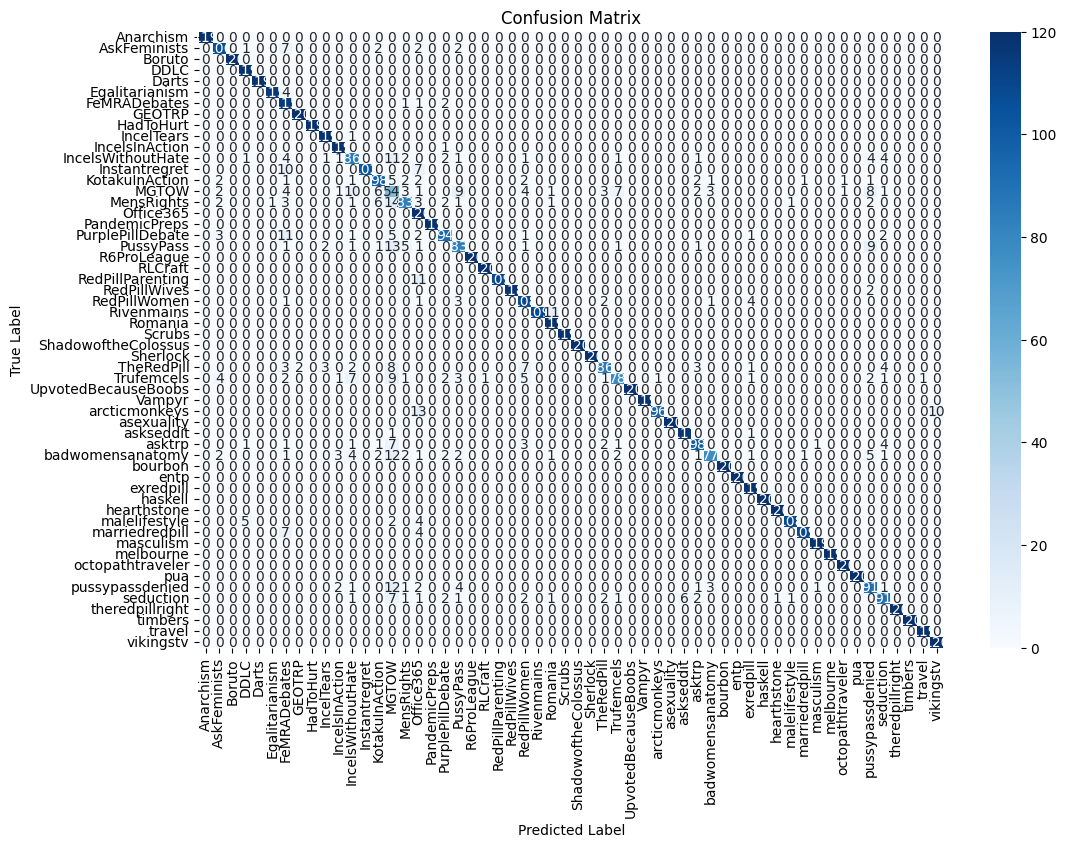

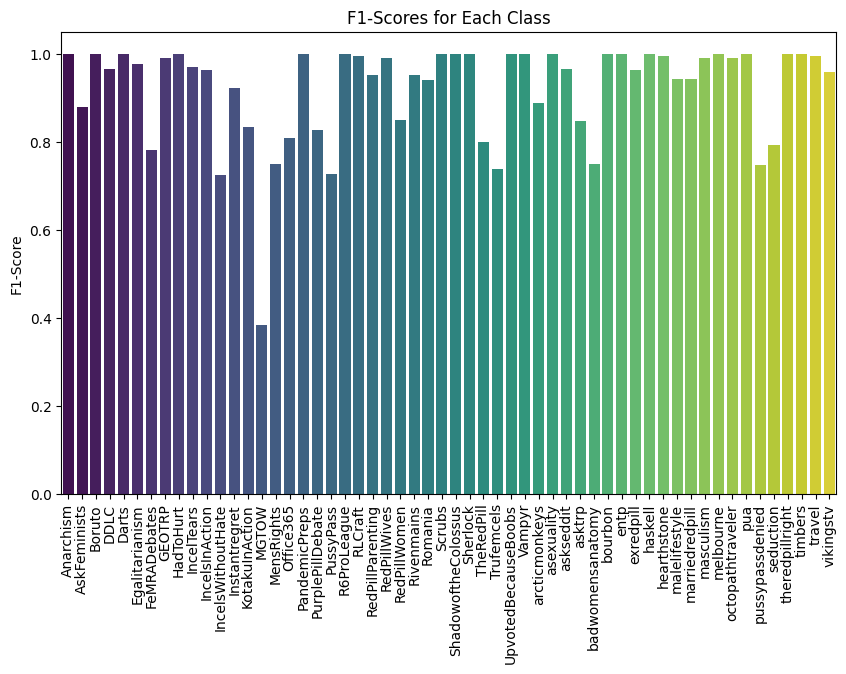

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np
import torch



cm = confusion_matrix(all_labels, all_preds)
labels = label_encoder.classes_

plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

report = classification_report(all_labels, all_preds, target_names=labels, output_dict=True)
report_df = pd.DataFrame(report).T

plt.figure(figsize=(10, 6))
sns.barplot(x=report_df.index[:-3], y=report_df['f1-score'][:-3], palette='viridis')
plt.xticks(rotation=90)
plt.ylabel("F1-Score")
plt.title("F1-Scores for Each Class")
plt.show()
